# Group test

In this notebook, we compare the performance of various group-based mutual exclusivity tests on simulated data.

In [1]:
import sys
sys.path.append("../lib")

In [2]:
import numpy
import pandas

In [3]:
import nbsupport.simulations
import nbsupport.plots
import nbsupport.roc
import nbsupport.tcga
import nbsupport.util

## Methods

We compared three variants of the group-based DISCOVER test to a large number of recently published methods: MEMo, muex, MEGSA, mutex, TiMEx, and CoMEt. Some of these methods (MEMo, MEGSA, mutex, CoMEt) combine a statistical test for mutual exclusivity with an algorithm to select groups of genes to test. In this comparison, we already have preselected groups of genes, and so only consider the mutual exclusivity tests.

### MEMo

MEMo is described in the following paper.

> Ciriello, G., Cerami, E., Sander, C. & Schultz, N. Mutual exclusivity analysis identifies oncogenic network modules. *Genome Res* **22**, 398–406 (2012), [doi:10.1101/gr.125567.111](http://doi.org/10.1101/gr.125567.111).

The MEMo permutation test uses information about which genes have been found recurrently altered. Since our simulated data are based on the TCGA breast cancer copy number gains, we use the recurrent gains of TCGA's GISTIC analysis.

In [4]:
amp_genes = numpy.concatenate(nbsupport.tcga.read_gistic_output("../data/tcga/amp_genes.conf_99.BRCA.txt").values())

In [5]:
from nbsupport import memo

### muex

The muex method is described in the following paper.

> Szczurek, E. & Beerenwinkel, N. Modeling mutual exclusivity of cancer mutations. *PLoS Comput Biol* **10**, e1003503 (2014), [doi:10.1371/journal.pcbi.1003503](http://doi.org/10.1371/journal.pcbi.1003503).

For the comparison described in the DISCOVER paper, we used the R package available from https://www1.ethz.ch/bsse/cbg/software/muex. At the time of submission, this web page was no longer accessible. The following import will use the muex R package (via [rpy2](http://rpy2.bitbucket.org/)) if it has already been installed, and resort to a Python-based reimplementation otherwise.

In [6]:
from nbsupport import muex

In [7]:
muex.__version__

'1.0'

### MEGSA

The MEGSA method is described in the following paper.

> Hua, X. et al. MEGSA: A Powerful and Flexible Framework for Analyzing Mutual Exclusivity of Tumor Mutations. *Am J Hum Genet* **98**, 442-455 (2016), [doi:10.1016/j.ajhg.2015.12.021](http://doi.org/10.1016/j.ajhg.2015.12.021).

In [8]:
from nbsupport import megsa

We use the R implementation made available by the authors, which can be downloaded from http://dceg.cancer.gov/tools/analysis/megsa/. The following command downloads the MEGSA source code, and imports it via rpy2.

In [9]:
megsa.install("../data/downloads")

### mutex

The mutex method is described in the following paper.

> Babur, Ö. et al. Systematic identification of cancer driving signaling pathways based on mutual exclusivity of genomic alterations. *Genome Biol* **16**, (2015), [doi:10.1186/s13059-015-0612-6](http://doi.org/10.1186/s13059-015-0612-6).

A Java implementation of the mutex method is available from https://github.com/pathwayanddataanalysis/mutex. The following module provides a Python implementation of the statistical test, which we have verified to give equivalent results to the Java version.

In [10]:
from nbsupport import mutex

### TiMEx

The TiMEx method is described in the following paper.

> Constantinescu, S. et al. TiMEx: a waiting time model for mutually exclusive cancer alterations. *Bioinformatics* **32**, 968-975 (2016), [doi:10.1093/bioinformatics/btv400](http://doi.org/10.1093/bioinformatics/btv400).

An R implementation of TiMEx is available from https://github.com/cbg-ethz/TiMEx. The following module imports this R package via rpy2. For it to work, the TiMEx R package needs to be installed first.

In [11]:
from nbsupport import timex

In [12]:
timex.__version__

'0.99.0'

### CoMEt

The CoMEt method is described in the following paper.

> Leiserson, M.D. et al. CoMEt: a statistical approach to identify combinations of mutually exclusive alterations in cancer. *Genom Biol* **16**, (2015), [doi:10.1186/s13059-015-0700-7](http://doi.org/10.1186/s13059-015-0700-7).

A software implementation of CoMEt is available from https://github.com/raphael-group/comet. Unfortunately, the computational complexity of the CoMEt test is so high that for some of the gene sets in this comparison the test will never finish. To deal with this, we use a patched version of the original implementation that interrupts the CoMEt exact test after 1 minute and returns the $P$ value obtained with the binomial approximation. The original CoMEt implementation uses a set of heuristics to decide between the exact test and the approximation, but we found those to be inadequate for this comparison.

In [13]:
from nbsupport import comet

Another measure we needed to take to deal with CoMEt's computational complexity is that we used IPython's parallel computing support. For this to work, an IPython cluster needs to be [started](https://ipyparallel.readthedocs.io/en/latest/process.html). The following code connects to such a cluster, but will only succeed if a cluster is found running on the local machine.

In [14]:
import ipyparallel
import os

client = ipyparallel.Client()
lview = client.load_balanced_view()

add_to_search_path_cmd = "__import__('sys').path.append('%s')" % os.path.abspath(os.path.join(nbsupport.__path__[0], ".."))
client[:].execute(add_to_search_path_cmd, block=True).wait()

True

### DISCOVER

The group-based DISCOVER test can be used with three different statistics: coverage, exclusivity, and impurity. A comparison of these statistics is presented below.

In [15]:
import discover

## Analyses

In this analysis, we generate simulated alteration matrices based on the TCGA breast cancer data. To these matrices we add groups of mutually exclusive genes, and also identify groups of independently altered genes of similar size and alteration frequency to serve as negative cases. We generate 10 such simulated data sets and plot averaged ROC, calibration, and sensitivity curves for each of the methods.

In [16]:
dataFile = "../data/tcga/tcga-pancan12.h5"

In [17]:
cn = pandas.read_hdf(dataFile, "/data/BRCA/cn")
gains = cn == 2

In [18]:
nbsupport.util.set_random_seed()

pvalues = []

for i in xrange(10):
    print i
    
    events = nbsupport.simulations.generate_independent_alterations(gains.sum(1), gains.sum(0))
    events, pos_groups, neg_groups = nbsupport.simulations.add_mutex_groups(events)
    groups = numpy.concatenate([neg_groups, pos_groups])
    
    # DISCOVER tests
    print "  DISCOVER"
    event_matrix = discover.DiscoverMatrix(pandas.DataFrame(events))
    pvalues_discover_coverage = [discover.groupwise_discover_test(event_matrix[group], "coverage") for group in groups]
    pvalues_discover_impurity = [discover.groupwise_discover_test(event_matrix[group], "impurity") for group in groups]
    pvalues_discover_exclusivity = [discover.groupwise_discover_test(event_matrix[group], "exclusivity") for group in groups]
    
    # MEMo
    print "  MEMo"
    selected_genes = numpy.unique(numpy.concatenate([
            gains.index.get_indexer(amp_genes),
            numpy.concatenate(pos_groups),
            numpy.concatenate(neg_groups)]))
    
    pvalues_memo = memo.memo_test(events, selected_genes, groups)
    
    # muex
    print "  muex"
    pvalues_muex = [muex.muex(events[group]).pvalue for group in groups]
    
    # MEGSA
    print "  MEGSA"
    pvalues_megsa = [megsa.megsa(events[group]) for group in groups]
    
    # mutex
    print "  mutex"
    pvalues_mutex = [mutex.mutex(events[group]) for group in groups]
    
    # TiMEx
    print "  TiMEx"
    pvalues_timex = timex.timex_test(events, groups)
    
    # comet
    print "  comet"
    pvalues_comet = lview.map(comet.comet_test, [events[group] for group in groups], block=True)
    
    pvalues.append({
            "cov": pvalues_discover_coverage,
            "imp": pvalues_discover_impurity,
            "exc": pvalues_discover_exclusivity,
            "memo": pvalues_memo,
            "muex": pvalues_muex,
            "megsa": pvalues_megsa,
            "mutex": pvalues_mutex,
            "timex": pvalues_timex,
            "comet": pvalues_comet
        })

0
  DISCOVER
  MEMo
  muex
  MEGSA
  mutex
  TiMEx
  comet
1
  DISCOVER
  MEMo
  muex
  MEGSA
  mutex
  TiMEx
  comet
2
  DISCOVER
  MEMo
  muex
  MEGSA
  mutex
  TiMEx
  comet
3
  DISCOVER
  MEMo
  muex
  MEGSA
  mutex
  TiMEx
  comet
4
  DISCOVER
  MEMo
  muex
  MEGSA
  mutex
  TiMEx
  comet
5
  DISCOVER
  MEMo
  muex
  MEGSA
  mutex
  TiMEx
  comet
6
  DISCOVER
  MEMo
  muex
  MEGSA
  mutex
  TiMEx
  comet
7
  DISCOVER
  MEMo
  muex
  MEGSA
  mutex
  TiMEx
  comet
8
  DISCOVER
  MEMo
  muex
  MEGSA
  mutex
  TiMEx
  comet
9
  DISCOVER
  MEMo
  muex
  MEGSA
  mutex
  TiMEx
  comet


## Plots

In [19]:
%matplotlib inline

In [20]:
labels = numpy.repeat([0, 1], [100, 100])

In [21]:
method_params_discover = [
    ("cov", "#d21716", "Coverage"),
    ("exc", "#3979ff", "Exclusivity"),
    ("imp", "#2a3441", "Impurity")
]

In [22]:
method_params = [
    ("imp", "#2a3441", "DISCOVER"),
    ("muex", "#edb132", "muex"),
    ("memo", "#33a02c", "MEMo"),
    ("megsa", "#e31a1c", "MEGSA"),
    ("mutex", "#377eb8", "mutex"),
    ("timex", "#b15928", "TiMEx"),
    ("comet", "#6a3d9a", "CoMEt")
]

### ROC curves

First, we compare the three variants of the DISCOVER test.

cov: 1.0
exc: 1.0
imp: 1.0


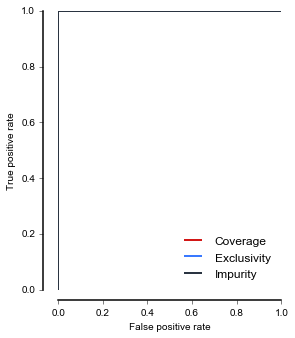

In [23]:
nbsupport.plots.plot_average_roc_curves(pvalues, labels, method_params_discover)

Then we compare the impurity-based DISCOVER test with the other methods.

imp: 1.0
muex: 0.84715
memo: 1.0
megsa: 0.994
mutex: 1.0
timex: 0.98672
comet: 1.0


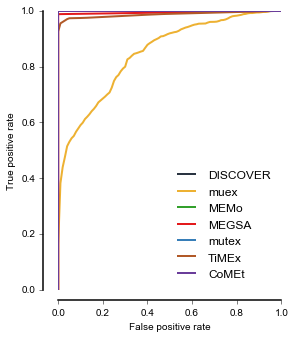

In [24]:
nbsupport.plots.plot_average_roc_curves(pvalues, labels, method_params)

### Calibration curves

A calibration curve plots the significance level $\alpha$ against the false positive rate.  For a statistical test, the significance level should
approximate the false positive rate. In such a case, the calibration curve
would be a diagonal line.

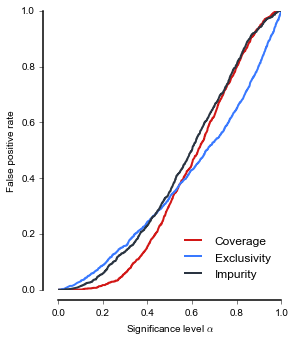

In [25]:
nbsupport.plots.plot_average_calibration_curves(pvalues, labels, method_params_discover)

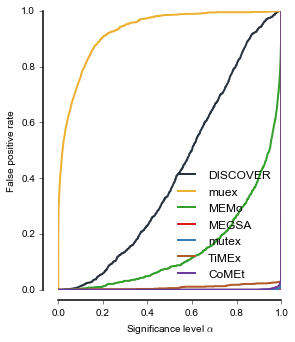

In [26]:
nbsupport.plots.plot_average_calibration_curves(pvalues, labels, method_params)

### Sensitivity curves

A sensitivity curve plots the significance level $\alpha$ against the true positive rate.  Since we are most interested in the sensitivity at low values of $\alpha$, the x-axis is plotted on a log-scale.

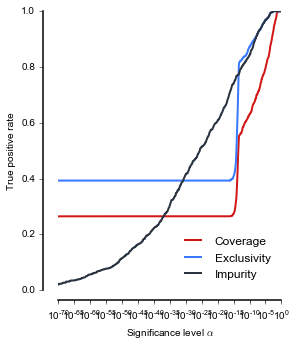

In [27]:
nbsupport.plots.plot_average_sensitivity_curves(pvalues, labels, method_params_discover)

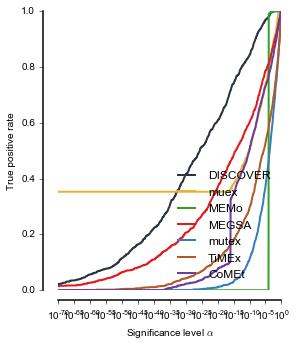

In [28]:
nbsupport.plots.plot_average_sensitivity_curves(pvalues, labels, method_params)